# 用于正式出图前的测试

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from scipy import stats

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import warnings
warnings.filterwarnings('ignore')  # 忽略无关警告

/home/longyh/miniforge3/envs/py310/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 加载临床信息文件

In [2]:
clinical_path='/work/longyh/BY/raw/1-s2.0-S0092867417311224-mmc2.xlsx'
clinical=pd.read_excel(clinical_path, skiprows=2)
print(clinical.columns)

Index(['Patient', 'Cohort', 'Response', 'Dead/Alive\n(Dead = True)',
       'Time to Death\n(weeks)', 'Subtype', 'Mutational\n Subtype', 'M Stage',
       'Mutation Load', 'Neo-antigen Load', 'Neo-peptide Load',
       'Cytolytic Score'],
      dtype='object')


In [10]:
clinical['Response'].value_counts()

Response
PD    31
SD    24
PR    12
NE     3
CR     3
Name: count, dtype: int64

In [3]:
clinical.head()

,Patient,Cohort,Response,Dead/Alive\n(Dead = True),Time to Death\n(weeks),Subtype,Mutational\n Subtype,M Stage,Mutation Load,Neo-antigen Load,Neo-peptide Load,Cytolytic Score
0,Pt1,NIV3-PROG,PD,True,22.857143,CUTANEOUS,NaN,M1C,NaN,NaN,NaN,977.869112
1,Pt10,NIV3-NAIVE,SD,True,36.571429,CUTANEOUS,NF1,M1A,75.0,33.0,56.0,65.840717
2,Pt100,NIV3-PROG,PD,True,120.000000,OTHER,TripleWt,M1C,6.0,5.0,6.0,NaN
3,Pt101,NIV3-PROG,PR,False,119.142857,CUTANEOUS,TripleWt,M1A,10.0,5.0,6.0,1392.142234
4,Pt102,NIV3-NAIVE,SD,False,90.857143,CUTANEOUS,RAS,NaN,393.0,248.0,770.0,NaN


## n=33队列

In [4]:
QC_path='/work/longyh/BY/processed/TNB/TNB_summary_n33.csv'
qc=pd.read_csv(QC_path)

In [5]:
print(qc.columns)
print(qc.shape)

Index(['sample', 'total_raw', 'total_unique', 'binding_only_raw',
       'binding_only_unique', 'ic50_500_tpm1_raw', 'ic50_500_tpm1_unique',
       'ic50_50_tpm5_raw', 'ic50_50_tpm5_unique', 'high_quality_raw',
       'high_quality_unique'],
      dtype='object')
(34, 11)


In [6]:
qc['binding_only_raw'].describe()

count       34.000000
mean       556.500000
std       1854.120542
min          0.000000
25%         74.000000
50%        171.000000
75%        341.500000
max      10962.000000
Name: binding_only_raw, dtype: float64

箱线图和散点图

In [16]:
# 数据预处理
clinical.rename(columns={'Patient': 'sample'}, inplace=True)
merged_df = pd.merge(qc, clinical, on='sample', how='inner')
merged_df = merged_df[merged_df['Response'] != 'NE'].copy()
response_map = {'CR':'Responder','PR':'Responder','SD':'Non-responder','PD':'Non-responder'}
merged_df['Response_group'] = merged_df['Response'].map(response_map)
merged_df['binding_only_log'] = np.log10(merged_df['binding_only_raw'] + 1)  # 对数变换


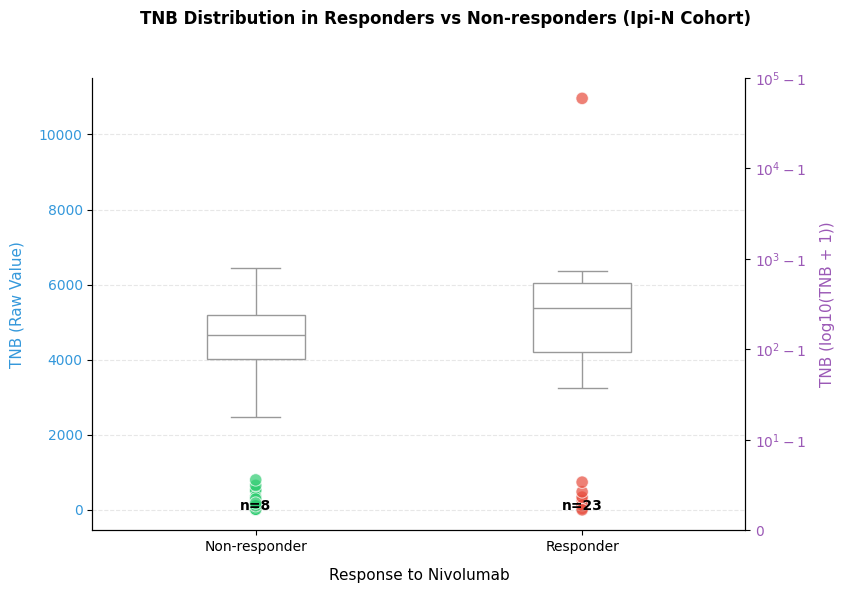

In [17]:

# 创建双Y轴
fig, ax1 = plt.subplots(figsize=(9, 6))

# 左侧Y轴：原始TNB值（散点图展示所有样本的真实值）
color1 = '#3498db'
ax1.set_xlabel('Response to Nivolumab', fontsize=11, labelpad=10)
ax1.set_ylabel('TNB (Raw Value)', color=color1, fontsize=11, labelpad=10)
# 散点图（按响应组着色，更直观）
sns.scatterplot(
    x='Response_group', 
    y='binding_only_raw', 
    data=merged_df,
    hue='Response_group',
    palette=['#2ecc71', '#e74c3c'],
    s=80,
    alpha=0.7,
    ax=ax1,
    legend=False
)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# 右侧Y轴：对数变换后的值（箱线图展示分布）
ax2 = ax1.twinx()
color2 = '#9b59b6'
ax2.set_ylabel('TNB (log10(TNB + 1))', color=color2, fontsize=11, labelpad=10)
# 箱线图（展示分布趋势）
sns.boxplot(
    x='Response_group', 
    y='binding_only_log', 
    data=merged_df,
    color='white',
    width=0.3,
    showfliers=False,
    ax=ax2
)
ax2.tick_params(axis='y', labelcolor=color2)
# 自定义对数轴刻度（方便解读）
max_log = merged_df['binding_only_log'].max()
yticks = [0, 1, 2, 3, 4, np.ceil(max_log)]
ytick_labels = [f'$10^{int(t)}-1$' if t !=0 else '0' for t in yticks]
ax2.set_yticks(yticks)
ax2.set_yticklabels(ytick_labels)

# 添加样本数标注
for i, group in enumerate(['Responder', 'Non-responder']):
    count = merged_df[merged_df['Response_group'] == group].shape[0]
    # 在X轴下方标注
    ax1.text(i, merged_df['binding_only_raw'].min()*0.8, 
             f'n={count}', ha='center', fontsize=10, fontweight='bold')

# 图表标题与美化
fig.suptitle('TNB Distribution in Responders vs Non-responders (Ipi-N Cohort)', 
             fontsize=12, fontweight='bold', y=0.98)
# 调整双轴间距，避免标签重叠
fig.tight_layout(rect=[0, 0, 0.95, 0.96])
sns.despine(top=True, right=False)
# plt.savefig('./results/tnb_response_dual_axis.png', dpi=300, bbox_inches='tight')
plt.show()

绘制ROC图

In [11]:
# ===================== 1. 数据预处理 =====================


# 合并数据（qc仅含Ipi-N队列）
clinical.rename(columns={'Patient': 'sample'}, inplace=True)
merged_df = pd.merge(qc, clinical, on='sample', how='inner')
assert qc['sample'].is_unique, "qc sample not unique"
assert clinical['sample'].is_unique, "clinical sample not unique"
# 1.1 严格定义响应分组（RECIST标准）
# 排除NE（无法评估）样本
merged_df = merged_df[merged_df['Response'] != 'NE'].copy()
# 响应者=CR/PR，非响应者=SD/PD
response_map = {
    'CR': 1,  # 响应者标记为1
    'PR': 1,
    'SD': 0,  # 非响应者标记为0
    'PD': 0
}
merged_df['response_label'] = merged_df['Response'].map(response_map)

# 1.2 过滤缺失值（确保TNB和响应标签都有值）
unknown = merged_df.loc[merged_df['Response'].notna() & merged_df['response_label'].isna(), 'Response'].value_counts()
print('unknown:', unknown)
roc_df = merged_df.dropna(subset=['binding_only_raw', 'response_label']).copy()

# 输出基础统计信息
total_samples = len(roc_df)
responder_count = roc_df[roc_df['response_label'] == 1].shape[0]
non_responder_count = roc_df[roc_df['response_label'] == 0].shape[0]
print(f"=== ROC分析基础统计 ===")
print(f"纳入分析总样本数：{total_samples}")
print(f"响应者（CR+PR）：{responder_count} 例")
print(f"非响应者（SD+PD）：{non_responder_count} 例")
print(f"TNB范围：{roc_df['binding_only_raw'].min():.0f} ~ {roc_df['binding_only_raw'].max():.0f}")
print(f"TNB中位数：{roc_df['binding_only_raw'].median():.0f}")


unknown: Series([], Name: count, dtype: int64)
=== ROC分析基础统计 ===
纳入分析总样本数：31
响应者（CR+PR）：8 例
非响应者（SD+PD）：23 例
TNB范围：0 ~ 10962
TNB中位数：167


In [9]:
# ===================== 2. 计算ROC曲线和AUC =====================
# 2.1 计算FPR、TPR和阈值
fpr, tpr, thresholds = roc_curve(
    roc_df['response_label'], 
    roc_df['binding_only_raw'],
    drop_intermediate=False  # 保留所有中间点，使曲线更平滑
)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# ...existing code...
# 2.2 使用 bootstrap 计算AUC的95%置信区间（小样本更稳健）
def bootstrap_auc_ci(ground_truth, predictions, n_bootstrap=2000, seed=42):
    """Bootstrap法计算AUC的95%置信区间"""
    rng = np.random.default_rng(seed)
    ground_truth = np.asarray(ground_truth)
    predictions = np.asarray(predictions)

    aucs = []
    skipped = 0

    for _ in range(n_bootstrap):
        idx = rng.integers(0, len(ground_truth), size=len(ground_truth))  # 有放回抽样
        y = ground_truth[idx]
        p = predictions[idx]

        # 跳过全0或全1的抽样
        if len(np.unique(y)) < 2:
            skipped += 1
            continue

        fpr_b, tpr_b, _ = roc_curve(y, p, drop_intermediate=False)
        aucs.append(auc(fpr_b, tpr_b))

    if len(aucs) == 0:
        return np.nan, np.nan, skipped / n_bootstrap

    ci_lower = np.percentile(aucs, 2.5)
    ci_upper = np.percentile(aucs, 97.5)
    return ci_lower, ci_upper, skipped / n_bootstrap

# 计算95%CI（bootstrap）
ci_lower, ci_upper, skip_ratio = bootstrap_auc_ci(
    roc_df['response_label'].values,
    roc_df['binding_only_raw'].values,
    n_bootstrap=2000,
    seed=42
)

# 确保CI在0-1范围内
ci_lower = max(0, ci_lower) if not np.isnan(ci_lower) else ci_lower
ci_upper = min(1, ci_upper) if not np.isnan(ci_upper) else ci_upper

print(f"Bootstrap跳过比例（全0/全1抽样）：{skip_ratio:.3%}")
# ...existing code...


Bootstrap跳过比例（全0/全1抽样）：0.000%


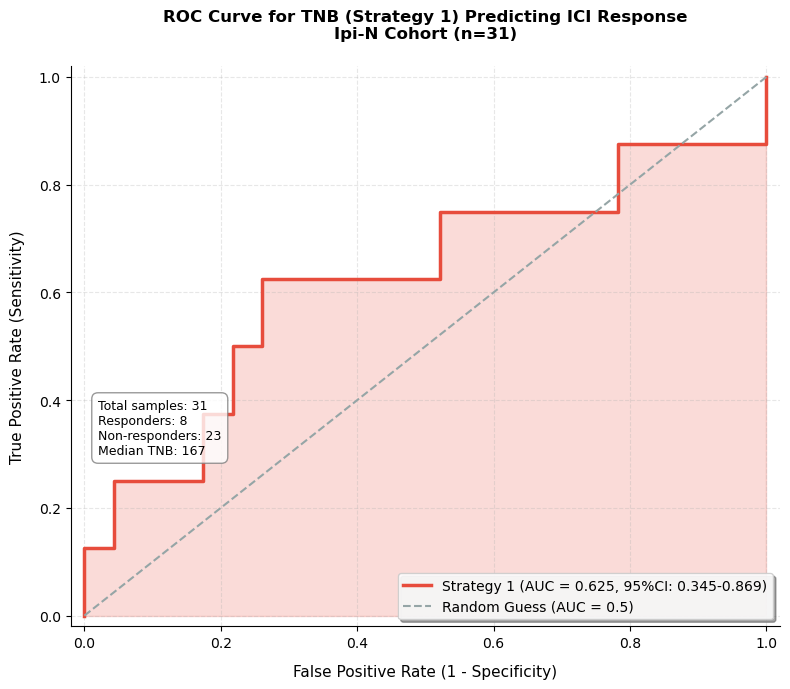


=== ROC分析结果 ===
AUC值：0.625
AUC 95%置信区间：[0.345, 0.869]


In [ ]:

# ===================== 3. 绘制专业ROC曲线 =====================
plt.figure(figsize=(8, 7))

# 3.1 绘制ROC曲线
plt.plot(
    fpr, tpr, 
    color='#e74c3c',  # 红色主曲线
    lw=2.5, 
    label=f'Strategy 1 (AUC = {roc_auc:.3f}, 95%CI: {ci_lower:.3f}-{ci_upper:.3f})'
)

# 3.2 绘制参考线（对角线）
plt.plot(
    [0, 1], [0, 1], 
    color='#95a5a6', 
    lw=1.5, 
    linestyle='--',
    label='Random Guess (AUC = 0.5)'
)

# 3.3 填充AUC区域（增强视觉效果）
plt.fill_between(fpr, tpr, alpha=0.2, color='#e74c3c')

# 3.4 图表美化
plt.xlim([-0.02, 1.02])  # 轻微扩展范围，避免曲线贴边
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=11, labelpad=10)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=11, labelpad=10)
plt.title('ROC Curve for TNB (Strategy 1) Predicting ICI Response\nIpi-N Cohort (n={})'.format(total_samples), 
          fontsize=12, fontweight='bold', pad=20)

# 3.5 自定义图例
plt.legend(
    loc="lower right", 
    fontsize=10,
    frameon=True,
    shadow=True,
    fancybox=True,
    framealpha=0.9
)

# 3.6 添加网格和样式优化
plt.grid(linestyle='--', alpha=0.3, linewidth=0.8)
sns.despine(top=True, right=True)  # 移除顶部和右侧边框

# 3.7 添加统计信息文本框
stats_text = f"""
Total samples: {total_samples}
Responders: {responder_count}
Non-responders: {non_responder_count}
Median TNB: {roc_df['binding_only_raw'].median():.0f}
"""
plt.text(
    0.02, 0.3, 
    stats_text.strip(), 
    fontsize=9,
    bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8)
)

# ===================== 4. 保存和显示 =====================
plt.tight_layout()
# 保存高分辨率图片
# plt.savefig(
#     './tnb_strategy1_roc.png', 
#     dpi=300, 
#     bbox_inches='tight',  # 避免标签被裁剪
#     facecolor='white'     # 背景为白色
# )
plt.show()

# 输出最终结果
print(f"\n=== ROC分析结果 ===")
print(f"AUC值：{roc_auc:.3f}")
print(f"AUC 95%置信区间：[{ci_lower:.3f}, {ci_upper:.3f}]")

KM生存曲线

In [5]:
# ===================== 1. 数据预处理 =====================
# 合并数据（qc仅含Ipi-N队列）
clinical.rename(columns={'Patient': 'sample'}, inplace=True)
merged_df = pd.merge(qc, clinical, on='sample', how='inner')

# 1.1 定义响应分组（排除NE）
merged_df = merged_df[merged_df['Response'] != 'NE'].copy()

# 1.2 统一生存数据列名（适配你的临床数据格式）
# 注意：确认列名与你的数据匹配，以下是基于你提供的列名的适配
merged_df.rename(columns={
    'Time to Death\n(weeks)': 'survival_time',  # 生存时间（周）
    'Dead/Alive\n(Dead = True)': 'event_indicator'  # 结局事件（True=死亡/事件发生，False=截尾）
}, inplace=True)

# 1.3 数据清洗：过滤生存数据缺失的样本
km_df = merged_df.dropna(subset=['binding_only_raw', 'survival_time', 'event_indicator']).copy()

# 1.4 定义高低TNB组（两种分组方式可选，推荐用中位值，也可改用三分位数）
## 方式1：中位值分组（临床研究最常用）
median_tnb = km_df['binding_only_raw'].median()
km_df['tnb_group'] = km_df['binding_only_raw'].apply(
    lambda x: 'High TNB' if x > median_tnb else 'Low TNB'
)

## 方式2：三分位数分组（若样本量足够，可选，注释掉方式1后启用）
# q33, q66 = km_df['binding_only_raw'].quantile([0.33, 0.66])
# km_df['tnb_group'] = pd.cut(
#     km_df['binding_only_raw'],
#     bins=[0, q33, q66, np.inf],
#     labels=['Low TNB', 'Medium TNB', 'High TNB']
# )

# 输出生存分析基础统计
print(f"=== 生存分析基础统计 ===")
print(f"纳入分析总样本数：{len(km_df)}")
print(f"TNB中位值：{median_tnb:.0f}")
for group in km_df['tnb_group'].unique():
    group_df = km_df[km_df['tnb_group'] == group]
    event_count = group_df['event_indicator'].sum()  # 事件发生数
    total_count = len(group_df)
    median_survival = group_df['survival_time'].median()
    print(f"{group}组：n={total_count}, 事件数={event_count}, 中位生存时间={median_survival:.1f}周")


=== 生存分析基础统计 ===
纳入分析总样本数：31
TNB中位值：167
High TNB组：n=15, 事件数=7, 中位生存时间=105.4周
Low TNB组：n=16, 事件数=10, 中位生存时间=53.7周


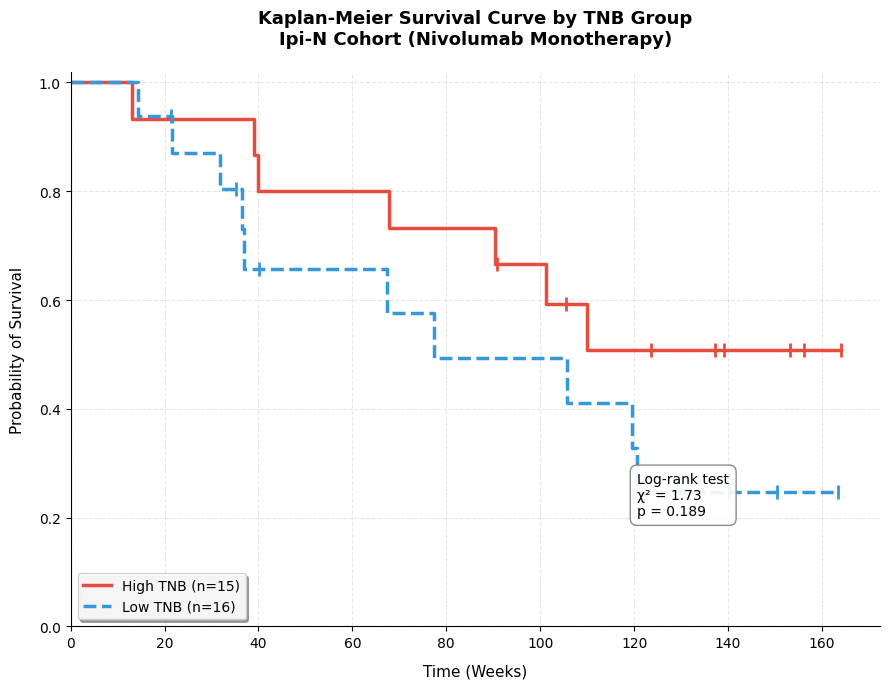


=== 生存分析结果 ===
Log-rank检验χ²值：1.73
Log-rank检验P值：0.189
高TNB组中位生存时间：105.4周
低TNB组中位生存时间：53.7周


In [6]:



# ===================== 2. 拟合Kaplan-Meier模型并计算Log-rank检验 =====================
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(9, 7))

# 2.1 拟合并绘制高低TNB组生存曲线
# 高TNB组
kmf.fit(
    durations=km_df[km_df['tnb_group']=='High TNB']['survival_time'],
    event_observed=km_df[km_df['tnb_group']=='High TNB']['event_indicator'],
    label='High TNB (n={})'.format(len(km_df[km_df['tnb_group']=='High TNB']))
)
kmf.plot(
    ax=ax,
    linestyle='-',
    linewidth=2.5,
    color='#e74c3c',
    ci_show=False,  # 关闭置信区间（样本量小时CI宽，影响美观）
    marker='None'
)

# 低TNB组
kmf.fit(
    durations=km_df[km_df['tnb_group']=='Low TNB']['survival_time'],
    event_observed=km_df[km_df['tnb_group']=='Low TNB']['event_indicator'],
    label='Low TNB (n={})'.format(len(km_df[km_df['tnb_group']=='Low TNB']))
)
kmf.plot(
    ax=ax,
    linestyle='--',
    linewidth=2.5,
    color='#3498db',
    ci_show=False,
    marker='None'
)

# 2.2 计算Log-rank检验（生存曲线差异的统计学显著性）
lr_test = logrank_test(
    durations_A=km_df[km_df['tnb_group']=='High TNB']['survival_time'],
    durations_B=km_df[km_df['tnb_group']=='Low TNB']['survival_time'],
    event_observed_A=km_df[km_df['tnb_group']=='High TNB']['event_indicator'],
    event_observed_B=km_df[km_df['tnb_group']=='Low TNB']['event_indicator']
)
lr_p_value = lr_test.p_value
lr_test_stat = lr_test.test_statistic

# ===================== 3. 图表美化与标注 =====================
# 3.1 核心标注：Log-rank检验结果
ax.text(
    0.7, 0.2,  # 位置（可根据实际曲线调整）
    f'Log-rank test\nχ² = {lr_test_stat:.2f}\np = {lr_p_value:.3f}',
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.9),
    transform=ax.transAxes  # 相对坐标，避免随X/Y轴缩放
)

# 3.2 坐标轴与标题设置
ax.set_title(
    'Kaplan-Meier Survival Curve by TNB Group\nIpi-N Cohort (Nivolumab Monotherapy)',
    fontsize=13, fontweight='bold', pad=20
)
ax.set_xlabel('Time (Weeks)', fontsize=11, labelpad=10)
ax.set_ylabel('Probability of Survival', fontsize=11, labelpad=10)

# 3.3 坐标轴范围优化
max_time = km_df['survival_time'].max()
ax.set_xlim(0, max_time * 1.05)
ax.set_ylim(0, 1.02)

# 3.4 网格与样式
ax.grid(linestyle='--', alpha=0.3, linewidth=0.8)
sns.despine(top=True, right=True)  # 移除多余边框

# 3.5 图例优化
ax.legend(
    loc='lower left',
    fontsize=10,
    frameon=True,
    shadow=True,
    fancybox=True,
    framealpha=0.9
)

# 3.6 添加截尾数据标注（可选，若有截尾值）
censored_high = km_df[(km_df['tnb_group']=='High TNB') & (km_df['event_indicator']==False)]
censored_low = km_df[(km_df['tnb_group']=='Low TNB') & (km_df['event_indicator']==False)]
# 绘制截尾标记（小竖线）
if not censored_high.empty:
    ax.scatter(
        censored_high['survival_time'],
        [ax.lines[0].get_ydata()[list(ax.lines[0].get_xdata()).index(t)] for t in censored_high['survival_time']],
        marker='|', color='#e74c3c', s=100, linewidth=2
    )
if not censored_low.empty:
    ax.scatter(
        censored_low['survival_time'],
        [ax.lines[1].get_ydata()[list(ax.lines[1].get_xdata()).index(t)] for t in censored_low['survival_time']],
        marker='|', color='#3498db', s=100, linewidth=2
    )

# ===================== 4. 保存与输出 =====================
plt.tight_layout()
# 保存高分辨率图片（适配学术发表）
plt.savefig(
    './tnb_km_survival_curve.png',
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)
plt.show()

# 输出生存分析关键结果
print(f"\n=== 生存分析结果 ===")
print(f"Log-rank检验χ²值：{lr_test_stat:.2f}")
print(f"Log-rank检验P值：{lr_p_value:.3f}")
print(f"高TNB组中位生存时间：{km_df[km_df['tnb_group']=='High TNB']['survival_time'].median():.1f}周")
print(f"低TNB组中位生存时间：{km_df[km_df['tnb_group']=='Low TNB']['survival_time'].median():.1f}周")